<a href="https://colab.research.google.com/github/PokeMaster16/Machine-Learning-Projects/blob/main/fcc_cat_dog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [8]:
# Get project files
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

!unzip cats_and_dogs.zip

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

--2025-09-25 21:04:44--  https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.2.33, 172.67.70.149, 104.26.3.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.2.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70702765 (67M) [application/zip]
Saving to: ‘cats_and_dogs.zip.2’

cats_and_dogs.zip.2 100%[===================>]  67.43M   231MB/s    in 0.3s    

2025-09-25 21:04:44 (231 MB/s) - ‘cats_and_dogs.zip.2’ saved [70702765/70702765]

Archive:  cats_and_dogs.zip
replace cats_and_dogs/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Step 1: Create the ImageDataGenerator instances for preprocessing
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

seed = 42
np.random.seed(seed)
tf.random.set_seed

# Step 2: Set up the flow_from_directory method to load images
train_data_gen = train_datagen.flow_from_directory(
    train_dir,
    batch_size=batch_size,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary',  # binary because it's cats vs dogs
    shuffle=True,
    seed=seed
)

validation_data_gen = validation_datagen.flow_from_directory(
    validation_dir,
    batch_size=batch_size,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary',  # binary because it's cats vs dogs
    shuffle=False,
    seed=seed
)

test_data_gen = test_datagen.flow_from_directory(
    test_dir,
    batch_size=batch_size,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode=None,  # No labels needed for test set
    shuffle=False,
    seed=seed

)
print(len(os.listdir(test_dir)))

for file_name in os.listdir(test_dir):
    print(file_name, os.path.splitext(file_name)[-1])

# Check if a 'temp_class' folder exists
dummy_test_dir = os.path.join(test_dir, 'temp_class')

if not os.path.exists(dummy_test_dir):
    os.makedirs(dummy_test_dir)

# Move all files into the 'temp_class' folder
for file_name in os.listdir(test_dir):
    file_path = os.path.join(test_dir, file_name)
    if os.path.isfile(file_path):  # Ensure it's a file and not a directory
        os.rename(file_path, os.path.join(dummy_test_dir, file_name))

# After moving the files, try loading the test data again
test_data_gen = test_datagen.flow_from_directory(
    dummy_test_dir,
    batch_size=batch_size,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode=None,
    shuffle=False
)

print("Contents of test directory:")
for file_name in os.listdir(test_dir):
    print(file_name)


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.
1
temp_class 
Found 0 images belonging to 0 classes.
Contents of test directory:
temp_class


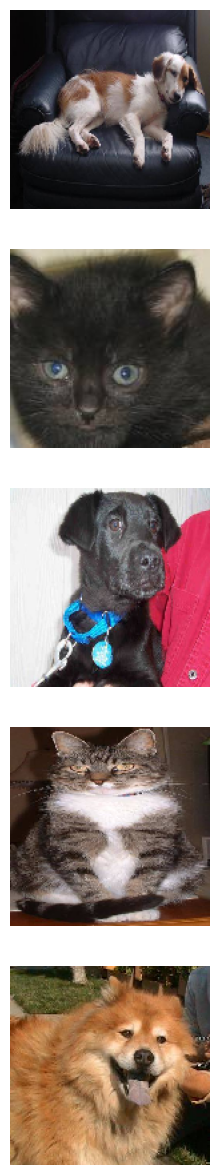

In [13]:
# 4
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])


In [14]:
# 5
train_image_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


Found 2000 images belonging to 2 classes.


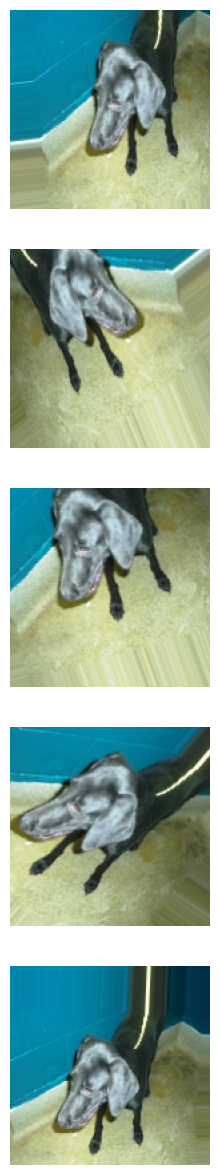

In [15]:
# 6
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 148, 148, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 72, 72, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 34, 34, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 15, 15, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     3,211,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,454,529 (13.18 MB)

 Trainable params: 3,453,825 (13.18 MB)

 Non-trainable params: 704 (2.75 KB)

In [17]:
# 8
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy','precision'] # -> Reforce the learning
)

history =  model.fit(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=20,
    validation_data=validation_data_gen,
    validation_steps=total_val // batch_size
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 171s 11s/step - accuracy: 0.5276 - loss: 3.5501 - precision: 0.5227 - val_accuracy: 0.5536 - val_loss: 0.6762 - val_precision: 0.3333
Epoch 2/20
 1/15 ━━━━━━━━━━━━━━━━━━━━ 1:54 8s/step - accuracy: 0.5703 - loss: 0.7664 - precision: 0.5738

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


15/15 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.5703 - loss: 0.7664 - precision: 0.5738 - val_accuracy: 0.5558 - val_loss: 0.6780 - val_precision: 0.3333
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 155s 10s/step - accuracy: 0.5813 - loss: 0.8742 - precision: 0.5873 - val_accuracy: 0.5592 - val_loss: 0.7220 - val_precision: 1.0000
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.5312 - loss: 0.7771 - precision: 0.4868 - val_accuracy: 0.5592 - val_loss: 0.7501 - val_precision: 1.0000
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 155s 11s/step - accuracy: 0.6217 - loss: 0.6824 - precision: 0.6229 - val_accuracy: 0.5580 - val_loss: 1.0137 - val_precision: 0.0000e+00
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.5781 - loss: 0.6907 - precision: 0.5397 - val_accuracy: 0.5592 - val_loss: 0.9489 - val_precision: 1.0000
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 171s 11s/step - accuracy: 0.6146 - loss: 0.6643 - precision: 0.6003 - val_accuracy: 0.5603 - val_loss: 1.0012 - val

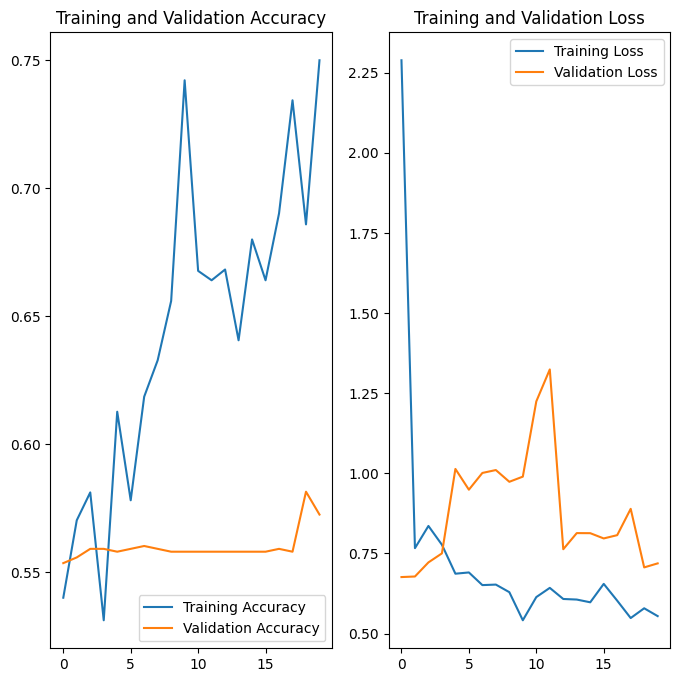

In [18]:
# 9
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range((len(acc)))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [19]:
def plot_images_with_probs(images, probs, true_labels=None, class_names=['Cat', 'Dog']):
    plt.figure(figsize=(12, 8))
    for i in range(len(images)):
        plt.subplot(3, 4, i + 1)
        plt.imshow(images[i])
        pred_idx = int(probs[i] > 0.5)
        pred_label = class_names[pred_idx]
        confidence = probs[i] if pred_idx == 1 else 1 - probs[i]

        if true_labels is not None:
            true_label = class_names[int(true_labels[i])]
            title_color = 'green' if pred_label == true_label else 'red'
            title = f"Pred: {pred_label} ({confidence:.2f})\nTrue: {true_label}"
        else:
            title_color = 'black'
            title = f"{pred_label} ({confidence:.2f})"

        plt.title(title, color=title_color)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

images, labels = next(validation_data_gen)
probabilities = model.predict(images)



4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 587ms/step


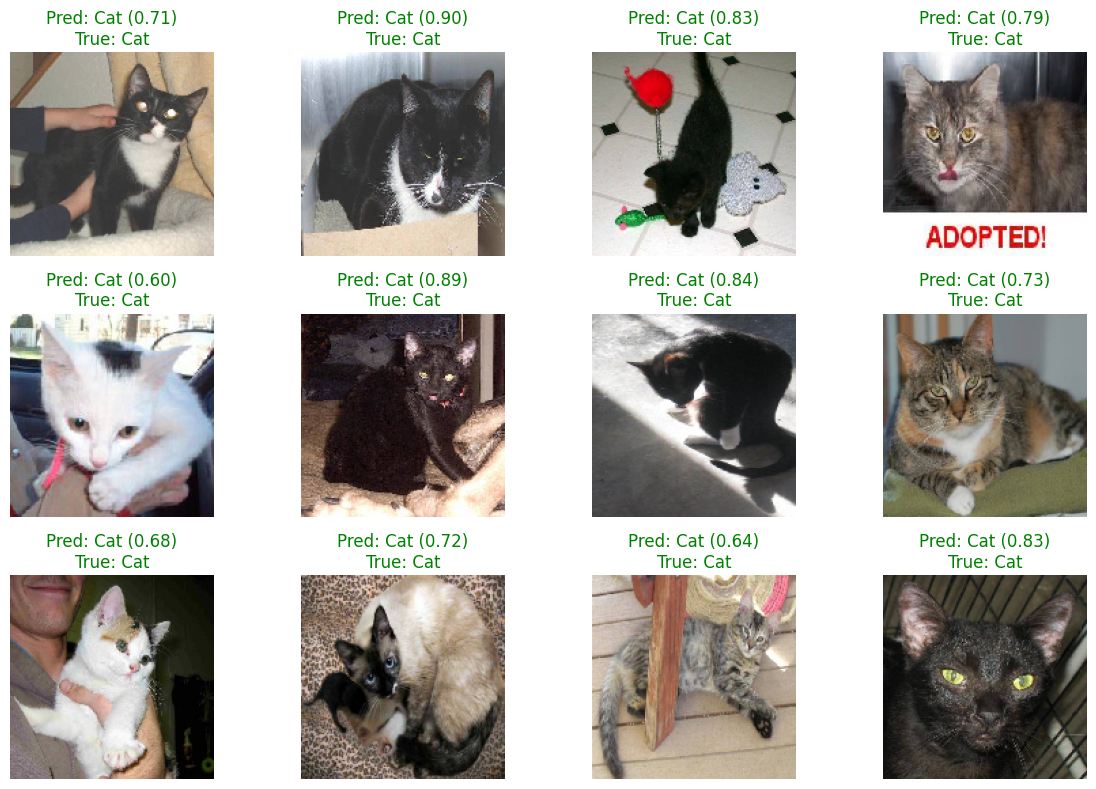

In [20]:
probs = probabilities.flatten()

plot_images_with_probs(images[:12], probs[:12], labels[:12])

In [21]:
# 11
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if round(float(probability)) == answer:
    correct +=1

percentage_identified = (correct / len(answers)) * 100

passed_challenge = percentage_identified >= 63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

Your model correctly identified 58.0% of the images of cats and dogs.
You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!


/tmp/ipython-input-2870262990.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if round(float(probability)) == answer:
